<a href="https://colab.research.google.com/github/joselvira/BiomecanicaPython/blob/master/Notebooks/Digitalizar_con_Blender_y_Python.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Cómo digitalizar vídeos con Blender

Blender es un programa de animación 3D con múltiples posibilidades. Una de ellas es que dispone de una herramienta de tracking o digitalización de puntos de forma automática que funciona muy bien. Se pueden exportar archivos con las coordenadasde los marcadores digitalizados y utilizarlos para calcular los parámetros DLT y obtener coordenadas reales. Esto se puede hacer en 2D (con al menos 1 cámara, pero se pueden utilizar más) y en 3D (con dos o más cámaras).

Como en cualquier estudio fotogramétrico en el que queramos medir distancias, es necesario utilizar un **marco de calibración** (MC). para ello debemos utilizar un objeto de dimensiones conocidas que sirva para situar el sistema de referencias espacial y para calcular la escala de las imágenes.

Si disponemos de un objeto rectangular, podemos grabarlo en la misma escena y a la misma distancia de la cámara a la que se va a realizar el movimiento a analizar y ese será el vídeo del MC. Una de las esquinas del rectángulo (normalmente la inferior izquierda) será el punto cero del sistema de referencias, y los lados del rectángulo serán los ejes X e Y.

Otra opción es utilizar una barra con los extremos de un color destacado. Podemos colocar la barra en varias posiciones, asegurando que esté vertical, de manera que los extremos de la barra formen un rectángulo, eso sí, en distintos fotogramas. Si se utiliza este tipo de MC, lo ideal es que quede grabado en el mismo vídeo. Si se ha grabado con distintos vídeos, se deben juntar en uno mismo, por ejemplo con [VirtualDub](http://www.virtualdub.org/) que es un programa gratuido de edición sencilla de vídeo.

En Blender, entrar en el modo Motion Tracking. Abrir el vídeo. Crear marcadores (botón Add a la izquierda), nombrarlos e ir realizando el tracking. Este proceso se prodría explicar con más detalle, pero por el momento no tengo tanto tiempo y se pueden encontrar numerosos tutoriales en Youtube en los que se explica en profundidad cómo utilizarlo. En la siguiente figura se ve un ejemplo del vídeo de salto que corresponde al ejemplo tratado en este notebook.

In [4]:
from IPython.display import Image
Image(url='https://github.com/joselvira/BiomecanicaPython/raw/master/Datos/EjemploDLT/Blender_DigitalizacionModelo.png', height=400)

Una vez terminada la digitalización tanto del vídeo del MC como de los marcadores del modelo, hay que meterse en el modo Scripting de Blender y en un nuevo script de Python compiar el código de Python siguiente. No intentes ejecutarlo desde aquí porque solo funciona desde dentro de blender.

In [ ]:
"""
Exporta las coordenadas de marcadores digitalizados con Blender
Hay que ejecutarlo desde el editor Scripting de Blender con el vídeo digitalizado abierto.
Jose Luis Lpoez Elvira
Fecha: 21/05/2018

Adaptado de :
# http://scummos.blogspot.cz/2012/11/blender-exporting-camera-tracking.html
# https://gist.github.com/anonymous/31c915d611f0a84e5d33
"""

from __future__ import print_function
import bpy
import numpy as np

D = bpy.data

frameNums = True  # incluye num frames en el archivo
relativeCoords = False  # para hacer que las coordenadas sean relativas a las dimensiones del vídeo

#CARGA LOS DATOS DE COORDENADAS
for clip in D.movieclips:
    print('\nProcesando video {}'.format(clip.name))
    
    markers = {}
    marcadores = {} #guarda los datos de cada marcador
    nomMarcadores = []
    nomVideo = bpy.data.filepath.split('.')[0] #guarda el archivo de las coordenadas con el mismo nombre que el archivo BLENDER
    #nomVideo = clip.name.split('.')[0] #guarda el archivo de las coordenadas con el mismo nombre que archivo de VÍDEO
        
    if relativeCoords:
        width = 1
        height = 1
    else:
        width = clip.size[0]
        height = clip.size[1]
    for ob in clip.tracking.objects:
        print('Procesando objeto {}'.format(ob.name))
        
        for track in ob.tracks:
            fn = '{}_{}_{}'.format(clip.name.split('.')[0], ob.name, track.name)
            markers[fn] = []
            marcadores[track.name] = []
            print('Marcador {} encontrado'.format(track.name))
            nomMarcadores.append(track.name)
            for framenum in range(clip.frame_duration):
                markerAtFrame = track.markers.find_frame(framenum)
                if markerAtFrame:
                    coords = list(markerAtFrame.co.xy)
                    coords = [coords[0] * width, coords[1] * height]
                    markers[fn].append(coords)
                    marcadores[track.name].append(coords)
                else: #si no está digitalizado este fotograma, lo deja en blanco. Es necesario para que no meta todas las filas juntas saltando huecos.
                    markers[fn].append(['', ''])
                    marcadores[track.name].append(['', ''])
                         
            
    #nomMarcadores=list(marcadores.keys())
    
    #print(len(marcadores), len(marcadores[nomMarcadores[0]]))
    #print(marcadores[nomMarcadores[0]])

    ##############################
    #ESCRIBE LOS DATOS DE TODOS LOS MARCADORES EN UN MISMO ARCHIVO
    print(len(marcadores))
    if len(marcadores) !=0:
        print('\nEscribiendo datos...')
        nombreArchivo= nomVideo + '_Marcadores.csv' #nombre del archivo de las coordenadas. Lo guarda en la misma carpeta del archivo de Blender.
        with open(nombreArchivo, 'w', newline='') as writer:
            #Escribe el encabezado
            encabezado=''
            if frameNums: encabezado+='frame,'
            for h in range(len(marcadores)):
                encabezado+='{},{},'.format(str(nomMarcadores[h])+'_x', str(nomMarcadores[h])+'_y')
                print('Marcador{}, con {} frames.'.format(nomMarcadores[h], len(marcadores[nomMarcadores[h]])))
            writer.write(encabezado[:-1]+'\n')
            
            #Escribe las coordenadas
            for i in range(len(marcadores[nomMarcadores[0]])):
                linea=''
                if frameNums: linea+=str(i)+','
                for h in nomMarcadores:
                    coordx=marcadores[h][i][0]
                    coordy=marcadores[h][i][1]
                    linea+='{},{},'.format(coordx, coordy)        
                writer.write(linea[:-1]+'\n')
            
        print('Terminado', nomVideo)            
    else:
        print('\nEl video {} no tiene marcadores.'.format(nomVideo))

En este caso, utilizaremos archivos ya preparados y digitalizados con Blender sobre un salto vertical con 5 marcadores.

# Cálculo de la DLT

Una vez tenemos los vídeos digitalizados y los archivos de las coordenadas exportados, procedemos a realizar los cálculos con Python, ya fuera del entorno Blender con el editor de código que utilicemos. Como ejemplo, utilizaremos los archivos de la carpeta /Datos/EjemploDLT/

En primer lugar, importamos los módulos necesarios.

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

También necesitaremos funciones para realizar la calibración y la reconstrucción de las coordenadas. para ello, utilizaremos como referencia las funciones de Marcos Duarte (a partir de https://www.mail-archive.com/floatcanvas@mithis.com/msg00513.html). Estas funciones podemos tenerlas en el propio código, o encapsularlas en un archivo aparte y llamarlo externamente, si sabemos cómo hacerlo. En este caso, por simplificar las incluiremos en el código.

In [ ]:
#https://www.mail-archive.com/floatcanvas@mithis.com/msg00513.html
#Marcos Duarte - [EMAIL PROTECTED] - 04dec08

import numpy as np

def DLTcalib(nd, xyz, uv):
    '''
    Camera calibration by DLT using known object points and their image points.

    This code performs 2D or 3D DLT camera calibration with any number of views (cameras).
    For 3D DLT, at least two views (cameras) are necessary.
    Inputs:
     nd is the number of dimensions of the object space: 3 for 3D DLT and 2 for 2D DLT.
     xyz are the coordinates in the object 3D or 2D space of the calibration points.
     uv are the coordinates in the image 2D space of these calibration points.
     The coordinates (x,y,z and u,v) are given as columns and the different points as rows.
     For the 2D DLT (object planar space), only the first 2 columns (x and y) are used.
     There must be at least 6 calibration points for the 3D DLT and 4 for the 2D DLT.
    Outputs:
     L: array of the 8 or 11 parameters of the calibration matrix
     err: error of the DLT (mean residual of the DLT transformation in units of camera coordinates).
    '''
    
    #Convert all variables to numpy array:
    xyz = np.asarray(xyz)
    uv = np.asarray(uv)
    #number of points:
    npo = xyz.shape[0]
    #Check the parameters:
    if uv.shape[0] != npo:
        raise(ValueError, 'xyz (%d points) and uv (%d points) have different number of points.' %(np, uv.shape[0]))
    if (nd == 2 and xyz.shape[1] != 2) or (nd == 3 and xyz.shape[1] != 3):
        raise(ValueError, 'Incorrect number of coordinates (%d) for %dD DLT (it should be %d).' %(xyz.shape[1],nd,nd))
    if nd == 3 and npo < 6 or nd == 2 and npo < 4:
        raise(ValueError, '%dD DLT requires at least %d calibration points. Only %d points were entered.' %(nd, 2*nd, npo))
        
    #Normalize the data to improve the DLT quality (DLT is dependent of the system of coordinates).
    #This is relevant when there is a considerable perspective distortion.
    #Normalization: mean position at origin and mean distance equals to 1 at each direction.
    Txyz, xyzn = Normalization(nd, xyz)
    Tuv, uvn = Normalization(2, uv)

    A = []
    if nd == 2: #2D DLT
        for i in range(npo):
            x,y = xyzn[i,0], xyzn[i,1]
            u,v = uvn[i,0], uvn[i,1]
            A.append( [x, y, 1, 0, 0, 0, -u*x, -u*y, -u] )
            A.append( [0, 0, 0, x, y, 1, -v*x, -v*y, -v] )
    elif nd == 3: #3D DLT
        for i in range(npo):
            x,y,z = xyzn[i,0], xyzn[i,1], xyzn[i,2]
            u,v = uvn[i,0], uvn[i,1]
            A.append( [x, y, z, 1, 0, 0, 0, 0, -u*x, -u*y, -u*z, -u] )
            A.append( [0, 0, 0, 0, x, y, z, 1, -v*x, -v*y, -v*z, -v] )

    #convert A to array
    A = np.asarray(A) 
    #Find the 11 (or 8 for 2D DLT) parameters:
    U, S, Vh = np.linalg.svd(A)
    #The parameters are in the last line of Vh and normalize them:
    L = Vh[-1,:] / Vh[-1,-1]
    #Camera projection matrix:
    H = L.reshape(3,nd+1)
    #Denormalization:
    H = np.dot( np.dot( np.linalg.pinv(Tuv), H ), Txyz );
    H = H / H[-1,-1]
    L = H.flatten('C') #ponía '0' pero daba warning deprecation
    #Mean error of the DLT (mean residual of the DLT transformation in units of camera coordinates):
    uv2 = np.dot( H, np.concatenate( (xyz.T, np.ones((1,xyz.shape[0]))) ) ) 
    uv2 = uv2/uv2[2,:] 
    #mean distance:
    err = np.sqrt( np.mean(np.sum( (uv2[0:2,:].T - uv)**2,1 )) ) 

    return L, err


def DLTrecon(nd, nc, Ls, uvs):
    '''
    Reconstruction of object point from image point(s) based on the DLT parameters.

    This code performs 2D or 3D DLT point reconstruction with any number of views (cameras).
    For 3D DLT, at least two views (cameras) are necessary.
    Inputs:
     nd is the number of dimensions of the object space: 3 for 3D DLT and 2 for 2D DLT.
     nc is the number of cameras (views) used.
     Ls (array type) are the camera calibration parameters of each camera 
      (is the output of DLTcalib function). The Ls parameters are given as columns
      and the Ls for different cameras as rows.
     uvs are the coordinates of the point in the image 2D space of each camera.
      The coordinates of the point are given as columns and the different views as rows.
    Outputs:
     xyz: point coordinates in space
    '''
    
    #Convert Ls to array:
    Ls = np.asarray(Ls) 
    #Check the parameters:
    if Ls.ndim ==1 and nc != 1:
        raise(ValueError, 'Number of views (%d) and number of sets of camera calibration parameters (1) are different.' %(nc))
    if Ls.ndim > 1 and nc != Ls.shape[0]:
        raise(ValueError, 'Number of views (%d) and number of sets of camera calibration parameters (%d) are different.' %(nc, Ls.shape[0]))
    if nd == 3 and Ls.ndim == 1:
        raise(ValueError, 'At least two sets of camera calibration parameters are needed for 3D point reconstruction.')

    if nc == 1: #2D and 1 camera (view), the simplest (and fastest) case
        #One could calculate inv(H) and input that to the code to speed up things if needed.
        Hinv = np.linalg.inv( Ls.reshape(3,3) )
        #Point coordinates in space:
        xyz = np.dot( Hinv,[uvs[0],uvs[1],1] ) 
        xyz = xyz[0:2]/xyz[2]       
    else:
        M = []
        for i in range(nc):
            L = Ls[i,:]
            u,v = uvs[i][0], uvs[i][1] #this indexing works for both list and numpy array
            if nd == 2:      
                M.append( [L[0]-u*L[6], L[1]-u*L[7], L[2]-u*L[8]] )
                M.append( [L[3]-v*L[6], L[4]-v*L[7], L[5]-v*L[8]] )
            elif nd == 3:  
                M.append( [L[0]-u*L[8], L[1]-u*L[9], L[2]-u*L[10], L[3]-u*L[11]] )
                M.append( [L[4]-v*L[8], L[5]-v*L[9], L[6]-v*L[10], L[7]-v*L[11]] )
        
        #Find the xyz coordinates:
        U, S, Vh = np.linalg.svd(np.asarray(M))
        #Point coordinates in space:
        xyz = Vh[-1,0:-1] / Vh[-1,-1]
    
    return xyz


def Normalization(nd,x):
    '''
    Normalization of coordinates (centroid to the origin and mean distance of sqrt(2 or 3).

    Inputs:
     nd: number of dimensions (2 for 2D; 3 for 3D)
     x: the data to be normalized (directions at different columns and points at rows)
    Outputs:
     Tr: the transformation matrix (translation plus scaling)
     x: the transformed data
    '''

    x = np.asarray(x)
    m, s = np.mean(x,0), np.std(x)
    if nd==2:
        Tr = np.array([[s, 0, m[0]], [0, s, m[1]], [0, 0, 1]])
    else:
        Tr = np.array([[s, 0, 0, m[0]], [0, s, 0, m[1]], [0, 0, s, m[2]], [0, 0, 0, 1]])
        
    Tr = np.linalg.inv(Tr)
    x = np.dot( Tr, np.concatenate( (x.T, np.ones((1,x.shape[0]))) ) )
    x = x[0:nd,:].T

    return Tr, x


Ajustamos los nombres de la carpeta donde se encuentran los archivos a tratar.

In [ ]:
carpetaOriginal = r'\Programas\Biomecanica\AnalisisImagen\Blender\PruebaTrackMarcadores'
nomArchMCTeorico = 'https://raw.githubusercontent.com/joselvira/BiomecanicaPython/master/Datos/EjemploDLT/Salto-MC-Teorico.csv' #archivo con las coordenadas reales del marco de calibración
nomArchMCDigit = 'https://raw.githubusercontent.com/joselvira/BiomecanicaPython/master/Datos/EjemploDLT/Salto-MC-Digitalizado.csv' #archivo con las coordenadas digitalizadas del marco de calibración
nomMarcadoresDigit = 'https://raw.githubusercontent.com/joselvira/BiomecanicaPython/master/Datos/EjemploDLT/Salto-MarcadoresModelo-Digitalizado.csv' #archivo con las coordenadas digitalizadas de los marcadores
separador= ','

Cargamos el archivo con las coordenadas reales de marco de calibración.

In [ ]:
MCTeorico = pd.read_csv(nomArchMCTeorico, sep=separador) #con values lo pasa directamente a array de numpy

El archivo tiene esta estructura:

In [ ]:
MCTeorico

,x,y
0,0,0
1,0,100
2,40,100
3,40,0


En columnas se encuentran las coordenadas x e y de cada punto teórico del marco de calibración. En filas están los puntos que componen el marco de calibración. En este caso son 4 puntos, formados por los extremos de una barra vertical colocada en dos posiciones concretas. La esquina inferior izquierda es el punto (0, 0), la barra tiene una altura de 100 cm, y la misma barra se vuelve a colocar 40 cm a la derecha. De este modo tenemos 4 puntos que forman un rectángulo de 40x100 cm, como se puede ver en la siguiente figura.

In [2]:
Image(url='https://github.com/joselvira/BiomecanicaPython/raw/master/Datos/EjemploDLT/Blender_DigitalizacionMarcoCalibracion.png', height=400)


Es importante resaltar que el orden de la definición de las coordenadas del marco de calibración teórico y el de digitalización de sus puntos debe ser el mismo. En este ejemplo el orden es:

1-Inferior izquierda (0,0)

2-Superior izquierda (0,100)

3-Superior derecha (40,100)

4-Inferior derecha (40,0)

Podemos crear una gráfica de tipo scatterplot para ver dónde se localizan los puntos.

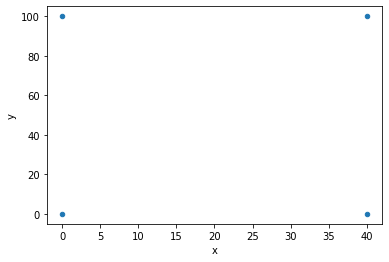

In [ ]:
MCTeorico.plot.scatter('x', 'y')

Para funcionar con las funciones del DLT necesitamos solo el array numpy, por lo que es mejor transformarlo de esta forma:

In [ ]:
MCTeorico = np.asarray(MCTeorico)
MCTeorico

array([[  0,   0],
       [  0, 100],
       [ 40, 100],
       [ 40,   0]])

Cargamos el archivo con las coordenadas digitalizadas del marco de calibración. Lo hacemos en varios pasos.

In [ ]:
MCDigit = pd.read_csv(nomArchMCDigit, header= 0, sep=separador, na_values=[' '])

Normalmente en los archivos del marco de calibración se digitalizan solo unos pocos fotogramas por marcador, por lo que el archivo está lleno de valores vacíos. Para ver sólo las coordenadas, podemos eliminar los valores nan (not a number). Aunque esto no es necesario porque a continuación calcularemos la media de cada marcadore en los fotogramas digitalizados.

In [ ]:
MCDigit.iloc[:, 1:].dropna(how='all') #elimina las filas en las que no hay ningún valor numérico

,InfIzq_x,InfIzq_y,SupIzq_x,SupIzq_y,SupDer_x,SupDer_y,InfDer_x,InfDer_y
1,207.354233,20.035230,204.370010,336.137764,NaN,NaN,NaN,NaN
2,207.501083,20.102323,204.516861,336.540344,NaN,NaN,NaN,NaN
3,207.060532,19.833953,203.635757,336.204826,NaN,NaN,NaN,NaN
4,207.354233,20.035230,203.635757,336.204803,NaN,NaN,NaN,NaN
5,207.354233,20.035233,204.076294,336.473167,NaN,NaN,NaN,NaN
602,NaN,NaN,NaN,NaN,309.241638,335.665306,311.924286,19.842509
603,NaN,NaN,NaN,NaN,309.241638,335.866653,311.924286,19.507047
604,NaN,NaN,NaN,NaN,308.801086,335.933762,312.071136,19.641232
605,NaN,NaN,NaN,NaN,308.947937,336.067978,312.071136,19.574139
606,NaN,NaN,NaN,NaN,309.094788,335.866676,312.217987,19.574139


En este caso concreto, se colocaba la barra primero en el lado izquierdo (se digitalizan los puntos inferior izquierdo y superior izquierdo) y después se colocaba en el lado derecho (superior derecho e inferior derecho). En el primer caso se han digitalizado los dos puntos en 5 fotogramas (del 1 al 5), mientras que en el segundo se han digitalizado en 6 fotogramas (del 602 al 607).

Si en lugar de utilizar una simple barra como marco de calibración se utiliza una estructura rectangular, todos los puntos del marco de calibración se ven simultáneamente en todos los fotogramas, por lo que se pueden digitalizar todos a la vez en cada fotograma.

Es conveniente digitalizar cada punto del modelo del marco de calibración varias veces para minimizar el error de localización y marcado. Posteriormente se calcula el promedio de cada marcador en todos los fotogramas en los que se haya digitalizado y se ordena para que quede con estructura de los marcadores en filas y las coordenadas x e y en columnas.

In [ ]:
#hay que transformar la estructura de filas-frames, columnas marcadores con x e y, a filas-marcadores, columnas x e y
MCDigit = MCDigit.iloc[:, 1:].mean() #quita columna frames y hace media de cada columna
MCDigit = np.asarray([MCDigit[::2], MCDigit[1::2]]).T #mete en un array las medias de x y de y y las transpone

El archivo tiene esta estructura, que corresponde a coordenadas de pixeles de la imagen.

In [ ]:
MCDigit

array([[207.32486267,  20.00839376],
       [204.04693604, 336.31218109],
       [309.0213623 , 335.88902664],
       [312.04176636,  19.62781305]])

Finalmente se cargan las coordenadas de los marcadores digitalizados. Posiblemente los primeros fotogramas salgan vacíos de datos, esto es porque las digitalizaciones empiezan más tarde.

In [ ]:
ModeloDigit = pd.read_table(nomMarcadoresDigit , header= 0, sep=separador, na_values=[' '])
ModeloDigit.head()

,frame,Cadera_x,Cadera_y,Rodilla_x,Rodilla_y,Tobillo_x,Tobillo_y,Talon_x,Talon_y,Meta_x,Meta_y
0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Como después nos vendrá bien, nos quedamos con los nombres de los marcadores

In [ ]:
nomMarcadores = [x[:-2] for x in ModeloDigit.iloc[:, 1::2].columns] #se queda con el nombre de los marcadores
nomMarcadores

['Cadera', 'Rodilla', 'Tobillo', 'Talon', 'Meta']

Para poder operar con las funciones del DLT, se quita la primera columna (frames) y se deja como array de numpy.

In [ ]:
ModeloDigit = ModeloDigit.iloc[:, 1:].values #quita columna frames y lo hace numpy
ModeloDigit

array([[         nan,          nan,          nan, ...,          nan,
                 nan,          nan],
       [         nan,          nan,          nan, ...,          nan,
                 nan,          nan],
       [         nan,          nan,          nan, ...,          nan,
                 nan,          nan],
       ...,
       [252.40542603, 261.87100983, 249.68392944, ...,  28.10670948,
        270.14099121,  18.70313215],
       [252.36895752, 261.83530426, 249.67323303, ...,  28.09943676,
        270.13189697,  18.70953941],
       [252.33334351, 261.80065155, 249.75402832, ...,  28.10488129,
        270.12280273,  18.71594667]])

A continuación se muestran las coordenadas de los marcadores digitalizados, en series temporales y como plano. Nótese que de momento están en coordenadas de píxeles de la imagen.

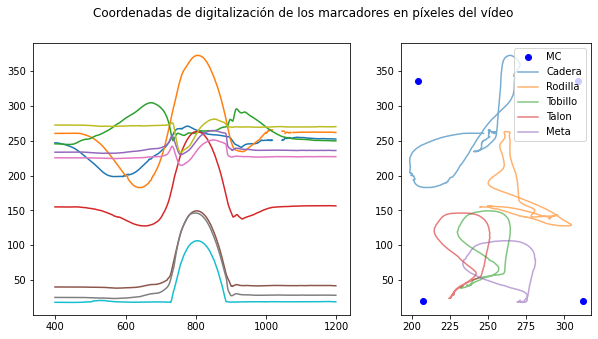

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(10,5), gridspec_kw = {'width_ratios':[2.5, 1.5]})
#Gráfica de cada marcador en series temporales
ax[0].plot(ModeloDigit)

#Puntos de referencia del marco de calibración
ax[1].plot(MCDigit[:,0], MCDigit[:,1], 'bo', label='MC')

#Gráfica del desplazamiento de cada marcador en el plano
for h in range(0, ModeloDigit.shape[1], 2):
    ax[1].plot(ModeloDigit[:,h], ModeloDigit[:,h+1], alpha=0.6, label='{}'.format(nomMarcadores[h//2]))
ax[1].legend()

plt.suptitle('Coordenadas de digitalización de los marcadores en píxeles del vídeo')
plt.show()

## Empieza a calcular la DLT

A continuación se realiza el proceso de reconstrucción de las coordenadas digitalizadas con los parámetros DLT calculados anteriormente, para obtener las coordenadas en distancia real.

In [ ]:
nd=2 #nº dimensiones
nc=1 #nº cámaras

#calcula parámetros de calibración
L1, err1 = DLTcalib(nd, MCTeorico, MCDigit)

#Reconstruye las coordenadas punto por punto
ModeloReconst = np.zeros((len(ModeloDigit), ModeloDigit.shape[1]))
for h in range(0, ModeloDigit.shape[1], 2):
    for i in range(len(ModeloDigit)):
        ModeloReconst[i, h:h+2] = DLTrecon( nd, nc, L1, ModeloDigit[i, h:h+2])

Finalmente muestra las coordenadas reconstruidas junto con los marcadores reales del marco de calibración. 

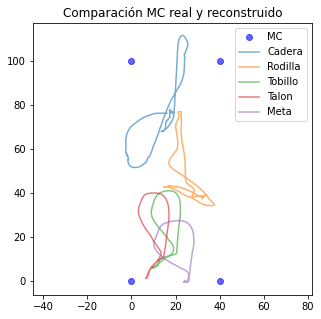

In [ ]:
fig, ax = plt.subplots(figsize=(5,5)) 
#representa los marcadores del marco de calibración
plt.plot(MCTeorico[:,0], MCTeorico[:,1], 'bo', alpha=0.6, label='MC')

#Representa las trayectorias de los marcadores del modelo
for h in range(0, ModeloReconst.shape[1], 2):
    plt.plot(ModeloReconst[:,h], ModeloReconst[:,h+1], alpha=0.6, label='{}'.format(nomMarcadores[h//2]))

ax.axis('equal') #hace que se vea en la misma proporción los ejes x e y
plt.legend()
plt.title('Comparación MC real y reconstruido')
plt.show()